In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
#from gprm.utils import pmag
import pygplates
from gprm.utils.create_gpml import gdf2gpml
from gprm.datasets import Reconstructions

import pygmt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

%matplotlib inline
%load_ext autoreload
%autoreload 2

mpl.rc('font',family='Helvetica')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2


def subdivide_by_ocean_basin(gdf):
    ocean_basin_polygons = gpd.read_file('../../NREE//gis/Polygons_of_Oceans/OceanBasinPolygons_reconstructed_0.00Ma.geojson')
    gdf_PacAtlInd = gdf.overlay(ocean_basin_polygons, how='intersection')
    gdf_Marginal = gdf.overlay(ocean_basin_polygons, how='difference')
    gdf_Marginal['NAME'] = 'Marginal Basins'

    return pd.concat([gdf_PacAtlInd, gdf_Marginal], ignore_index=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from gprm.datasets import Seafloor

mpicks = Seafloor.MagneticPicks()

mpicks = subdivide_by_ocean_basin(mpicks)

#mpicks
#print(mpicks.columns)

bins = np.arange(0,250,10)

mpicks_binned = mpicks.groupby(['NAME', pd.cut(mpicks['GeeK2007'], bins=bins)])
mpicks_heatmap = mpicks_binned.size().unstack()

mpicks_heatmap = mpicks_heatmap.reindex(['Atlantic', 'Indian', 'Pacific', 'Marginal'])

mpicks_heatmap

/opt/anaconda3/envs/pygmt7/lib/python3.8/site-packages/geopandas/geodataframe.py:2334: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS_84" ...
Right CRS: EPSG:4326

  return geopandas.overlay(
/opt/anaconda3/envs/pygmt7/lib/python3.8/site-packages/geopandas/geodataframe.py:2334: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS_84" ...
Right CRS: EPSG:4326

  return geopandas.overlay(


GeeK2007,"(0, 10]","(10, 20]","(20, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 70]","(70, 80]","(80, 90]","(90, 100]",...,"(140, 150]","(150, 160]","(160, 170]","(170, 180]","(180, 190]","(190, 200]","(200, 210]","(210, 220]","(220, 230]","(230, 240]"
NAME,,,,,,,,,,,,,,,,,,,,,
Atlantic,18099.0,6444.0,2483.0,2180.0,3453.0,2209.0,1051.0,2775.0,1229.0,0.0,...,237.0,208.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Indian,7999.0,4751.0,1563.0,1582.0,2400.0,2011.0,1646.0,956.0,338.0,0.0,...,380.0,159.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pacific,7880.0,4151.0,5347.0,3053.0,1368.0,1133.0,1623.0,758.0,171.0,0.0,...,577.0,776.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Marginal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
FractureZones = Seafloor.SeafloorFabric()

#FractureZones_gpml = gdf2gpml(FractureZones)

# We will treat the segment mid-points as the location where we can get the age
segments = []
for feature in gdf2gpml(FractureZones):
    geometry = feature.get_geometry()
    tessellated_geometry = geometry.to_tessellated(np.radians(0.1))
    for segment in tessellated_geometry.get_segments():
        segments.append([segment.get_arc_point(0.5).to_lat_lon()[1], 
                         segment.get_arc_point(0.5).to_lat_lon()[0],
                         segment.get_arc_length()*pygplates.Earth.mean_radius_in_kms])
        
FractureZoneSegments = pd.DataFrame(data=segments, columns=['Longitude', 'Latitude', 'arc_length'])
# TODO
# NB should try to get the median age from the vicinity, since by definition Fracture 
# Zones should bound two bits of seafloor with different ages
FractureZoneSegments['FZage'] = pygmt.grdtrack(points=FractureZoneSegments, 
                                               grid='/Applications/GPlates_2.3.0/GeoData/Rasters/Seafloor_Age_Grid/Seton_etal_2020_PresentDay_AgeGrid.nc',
                                               newcolname='z')['z']

FractureZoneSegments = gpd.GeoDataFrame(FractureZoneSegments, geometry=gpd.points_from_xy(FractureZoneSegments.Longitude, FractureZoneSegments.Latitude), crs=4326)

FractureZoneSegments = subdivide_by_ocean_basin(FractureZoneSegments)


#fig = pygmt.Figure()
#fig.coast(land="lightgray", region="d", projection="W9i")
#pygmt.makecpt(cmap='split', series=[0,120,10], reverse=True)
#fig.plot(x=FractureZoneSegments['Longitude'], y=FractureZoneSegments['Latitude'], color=FractureZoneSegments['FZage'], style='c0.025c', cmap=True)#
#fig.basemap(frame=True)
#fig.colorbar(position='JMR+o1c/0c+w6c/1c')
#fig.show(width=1000)

FractureZones_binned = FractureZoneSegments.groupby(['NAME', pd.cut(FractureZoneSegments['FZage'], bins=bins)])
FractureZones_heatmap = FractureZones_binned.size().unstack()

FractureZones_heatmap = FractureZones_heatmap.reindex(['Atlantic', 'Indian', 'Pacific', 'Marginal'])

grdtrack [WARNING]: Some input points were outside the grid domain(s).


In [6]:
gdf = gpd.read_file('../data/HotspotTrails.geojson')

print(gdf.Chain.unique())
gdf = gdf.dropna(subset=['Chain'])

gdf['ChainGroup'] = gdf['Chain']

#ind = gdf.Chain.isin(['Austral','Caroline','Cobb','Cook','Easter_Chain','Foundation',
#                      'Geologist','Japanese_Seamounts','Typhoon_Seamounts','Kodiak-Bowie','Line_Islands',
#                      'Magellan', 'Marcus-Wake','Marquesas','Marshall','Mid_Pacific_Mountains',
#                      'Musician','Necker_Rise','Pitcairn','Puka-Puka','Samoa','Society','Tarava',
#                      'Tuamotu','Plateau','Tokelau','Shatsky'])
ind = gdf.Chain.isin(['Cobb','Foundation','Musicians',
                      'Marcus-Wake','Mid_Pacific_Mountains',
                      'Samoa', 'Pitcairn','Shatsky','Tuamotu'])
gdf.loc[ind,'ChainGroup'] = 'Other Pacific'

ind = gdf.Chain.isin(['Tasmantid', 'Lord_Howe'])
gdf.loc[ind,'ChainGroup'] = 'Tasman Sea'

ind = gdf.ChainGroup.isin(['Hawaii','Louisville','Other Pacific','Reunion','Tasman Sea','Kerguelen',
                           'Tristan','Canary','St_Helena','New_England'])
trails_select = gdf[ind]

['Austral' 'Caroline' 'Cobb' 'Cook' 'Easter_Chain' 'Foundation'
 'Geologist' 'Hawaii' 'Japanese_Seamounts' 'Typhoon_Seamounts'
 'Kodiak-Bowie' 'Line_Islands' 'Louisville' 'Magellan' 'Marcus-Wake'
 'Marquesas' 'Marshall' 'Mid_Pacific_Mountains' 'Musician' 'Necker_Rise'
 'Pitcairn' 'Puka-Puka' 'Samoa' 'Society' 'Tarava' 'Tuamotu' 'Plateau'
 'Tokelau' 'Shatsky' 'New_England' 'Reunion' 'Tristan' 'Canary'
 'St_Helena' 'Kerguelen' 'Tasmantid' 'Lord_Howe']


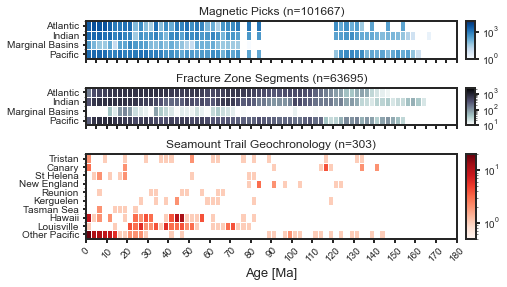

In [10]:
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
#plt.rcParams["axes.axisbelow"] = False


linewidth=0.5
linecolor = [0.2, 0.2, 0.2]
edgecolor = 'white'
edgewidth = 0.5
ytickfontsize = 10
titlefontsize = 12


binsize = 2.5
bins = np.arange(0,180.1,binsize)



fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(nrows=3, ncols=1, wspace=0.2, hspace=.55, height_ratios=[4,4,9])

####################################################
# Magnetic picks
mpicks_binned = mpicks.groupby(['NAME', pd.cut(mpicks['GeeK2007'], bins=bins)])
mpicks_heatmap = mpicks_binned.size().unstack()


nrows = mpicks_heatmap.shape[0]
ax00 = fig.add_subplot(gs[0])


p = ax00.pcolormesh(np.array(mpicks_heatmap), edgecolors=edgecolor, linewidth=edgewidth,
                    norm=colors.LogNorm(vmin=1, vmax=18000.), cmap='Blues')
ax00.invert_yaxis()
ax00.set(xlabel=None, ylabel=None)
ax00.set_xticks((bins[::2])/binsize)
ax00.set_xticklabels([])
#ax00.set_xticklabels([str(num) for num in bins[::2]], rotation=45.)
ax00.set_yticks(np.arange(len(mpicks_heatmap.index))+0.5, minor=False) 
ax00.set_yticklabels(mpicks_heatmap.index, fontsize=ytickfontsize)
ax00.set_yticks(np.arange(len(mpicks_heatmap.index)), minor=True) 
plt.colorbar(p, ax=ax00, aspect=4, pad=0.02)
ax00.set_title('Magnetic Picks (n={:d})'.format(mpicks_heatmap.sum().sum()), fontsize=titlefontsize)

####################################################
# Magnetic picks
FractureZones_binned = FractureZoneSegments.groupby(['NAME', pd.cut(FractureZoneSegments['FZage'], bins=bins)])
FractureZones_heatmap = FractureZones_binned.size().unstack()


nrows = FractureZones_heatmap.shape[0]
ax00 = fig.add_subplot(gs[1])


p = ax00.pcolormesh(np.array(FractureZones_heatmap), edgecolors=edgecolor, linewidth=edgewidth, 
                    norm=colors.LogNorm(vmin=10, vmax=2500.), cmap='bone_r')
ax00.invert_yaxis()
ax00.set(xlabel=None, ylabel=None)
ax00.set_xticks((bins[::2])/binsize)
ax00.set_xticklabels([])
#ax00.set_xticklabels([str(num) for num in bins[::2]], rotation=45.)
ax00.set_yticks(np.arange(len(FractureZones_heatmap.index))+0.5, minor=False) 
ax00.set_yticklabels(FractureZones_heatmap.index, fontsize=ytickfontsize)
ax00.set_yticks(np.arange(len(FractureZones_heatmap.index)), minor=True)
plt.colorbar(p, ax=ax00, aspect=4, pad=0.02)
ax00.set_title('Fracture Zone Segments (n={:d})'.format(FractureZones_heatmap.sum().sum()), fontsize=titlefontsize)


####################################################
# Hotspot Trails
trails_binned = trails_select.groupby(['ChainGroup', pd.cut(trails_select['Age'], bins=bins)])
trails_heatmap = trails_binned.size().unstack()
trails_heatmap = trails_heatmap.reindex(['Tristan','Canary','St_Helena','New_England',
                                         'Reunion','Kerguelen','Tasman Sea',
                                         'Hawaii','Louisville','Other Pacific'])
trails_heatmap = trails_heatmap.rename(index={'St_Helena': 'St Helena', 'New_England': 'New England'})

# Draw a heatmap with the numeric values in each cell
nrows = trails_heatmap.shape[0]
ax10 = fig.add_subplot(gs[2])

p = ax10.pcolormesh(np.array(trails_heatmap), edgecolors=edgecolor, linewidth=edgewidth, 
                    norm=colors.LogNorm(vmin=.5, vmax=20.), cmap='Reds')
ax10.invert_yaxis()
ax10.set(xlabel=None, ylabel=None)
ax10.set_xticks((bins[::4])/binsize)
ax10.set_xticklabels([])
ax10.set_xticklabels([str(int(num)) for num in bins[::4]], rotation=45., fontsize=ytickfontsize)
ax10.set_yticks(np.arange(len(trails_heatmap.index))+0.5, minor=False) 
ax10.set_yticklabels(trails_heatmap.index, fontsize=ytickfontsize)
ax10.set_yticks(np.arange(len(trails_heatmap.index)), minor=True) 
plt.colorbar(p, ax=ax10, aspect=8, pad=0.02)
ax10.set_title('Seamount Trail Geochronology (n={:d})'.format(int(trails_heatmap.sum().sum())), fontsize=titlefontsize)

ax10.set_xlabel('Age [Ma]', fontsize=13)
#ax10.tick_params(axis='x', which='major', labelsize=ytickfontsize)


plt.savefig('./ReconstructionBasisDataOceans.pdf', bbox_inches='tight')
plt.show()

In [ ]:
pac = pd.read_csv('/Users/simon/Data/zenodo/PHT2021/PHT2021_raw_data/PHT2021_pacific_ages.txt',
                  comment='#', sep=r'\t+', #delim_whitespace=True,
                  names=['Long', 'Lat', 'Average_Age_Ma', 'Average_Age_Error_Ma', 'Tag', 'SeamountName', 'SeamountChain'])

pac
